In [1]:
#Imports some of the libraries that we will be using
import pandas as pd
import numpy as np
import math
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


In [2]:
from load_dataset import load
from classifier import NeuralNetwork, Logistic_Regression, SVM
from utils import *
from metrics import *  # include fairness and corresponding derivatives
from expl import explanation_candidate_generation, get_top_k_expl
from influence import *

['classifier.py', 'compas-scores-two-years.csv', 'compas_if.ipynb', 'config.json', 'expl.py', 'functions.py', 'german.data', 'influence.py', 'influence_functions.ipynb', 'load_dataset.py', 'loss.py', 'metrics.py', 'utils.py', '__pycache__']


<h4>Build model and get teh influence points<h4>

In [3]:
dataset = 'german'
clf_name = 'Logistic_Regression'
metric = 0
support = 0.05
support_small = 0.3

In [4]:
X_train, X_test, y_train, y_test = load(dataset)

In [5]:
duplicates = 1
make_duplicates = lambda x, d: pd.concat([x]*d, axis=0).reset_index(drop=True)
X_train = make_duplicates(X_train, duplicates)
X_test = make_duplicates(X_test, duplicates)
y_train = make_duplicates(y_train, duplicates)
y_test = make_duplicates(y_test, duplicates)

In [6]:
len(X_train)

800

In [7]:
import copy
X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [8]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [9]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.09527579839341338
Initial TPR parity:  -0.07785149414194836
Initial predictive parity:  -0.10136869475949661
Initial accuracy:  0.755


In [10]:
metric_val = [spd_0, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta = get_del_F_del_theta(clf, X_test_orig, X_test, y_test, dataset, metric)

In [11]:
del_F_del_theta.shape

(32,)

In [12]:
hessian_all_points = get_hessian_all_points(clf, X_train, y_train, loss_func)

100%|██████████| 800/800 [00:13<00:00, 60.59it/s]


In [13]:
hessian_all_points.shape

(800, 32, 32)

In [14]:
del_L_del_theta = get_del_L_del_theta(clf, X_train, y_train, loss_func)

In [15]:
del_L_del_theta.shape

(800, 32)

In [16]:
hessian_all_points.shape

(800, 32, 32)

In [17]:
del_F_del_theta.shape

(32,)

In [18]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta))
#incorporate del_l_del_theta_i with the updated datapoint

In [19]:
hinv_v.shape

(32, 800)

In [20]:
del_F_del_theta.shape

(32,)

In [58]:
inf = np.matmul(np.transpose(hinv_v), del_F_del_theta)
#For the new datapoint re-calculate the hinv_v

In [60]:
max(inf)

2.56359037985851

<h4>Flip the datapoints and remove the datapoints and compare the parity values<h4>

In [22]:
predictors = ['status', 'duration', 'credit_hist', 'credit_amt', 'savings',
       'employment', 'install_rate', 'debtors', 'residence', 'property', 'age',
       'install_plans', 'num_credits', 'job', 'num_liable', 'telephone',
       'foreign_worker', 'gender', 'purpose_A40', 'purpose_A41',
       'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44',
       'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49',
       'housing_A151', 'housing_A152', 'housing_A153']
target_var =['credit_risk']

In [23]:
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(X_train_orig, columns = predictors)
train_outcome_df = y_train.to_frame()
train_outcome_df=train_outcome_df.rename(columns={'credit':'credit_risk'})
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [24]:
train_full_df['credit_risk'] = train_full_df['credit_risk'].replace({0: 2})

In [25]:
#Make changes to make more efficient
#Function used to run the DT model
#train_dataset: Training dataset to train the model
#independent_var: Column names
#dependent_var: Prediction column name
#concat_col: Name of column creating new DF on
def logistic_regression_updated(train_dataset, X_test_orig, y_test, independent_var, concat_col):
        #Split the data up into train and test values and then run the DT model
        #These steps aren't neccessary to consistenly do over and over again
        training_labels = train_dataset.pop('credit_risk')
        training_attributes = train_dataset
        #x = train_dataset[independent_var].values
        #y = train_dataset[dependent_var].values
        #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=310)
        clf = LogisticRegression(class_weight=None, max_iter=100)
        log = clf.fit(training_attributes,training_labels)
        prediction = log.predict(X_test_orig)

        train_dataset['credit_risk'] = training_labels
        #print(train_dataset)

        #Printing the Overall accuracy of the model after one run
        #F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
        #file.write(f'\nAccuracy of the model on Testing Sample Data: {F1_Score}')

        #Prints out the average across all ten run throughs
        #Accuracy_Values=cross_val_score(log, x , y, cv=10, scoring='f1_weighted')

        accuracy = accuracy_score(y_test,prediction)*100

        #After running the model I return a df with the datapoints and the labels
        test_demo_df = pd.DataFrame(X_test_orig, columns = independent_var)
        #Concat_col: credit_risk_12
        predicted_df = pd.DataFrame(prediction, columns = [concat_col])

        return accuracy, test_demo_df, predicted_df

In [26]:
#This function is being used to calculate the statistical parity of the data set
#test_data: The original data frame containing the test data
#predictors: List of the all the column names AKA IV's
#prediction_df: Contains the predicitons made by the DT model
#sensitive_attr: Name of the sensitive attr
#sensitive_attr_cutoff: Cut off value for sensitive attr
#concat_col: Name of column I am creating new dataframe on
def s_parity(test_data, predictors, prediction_df, sensitive_attr, sensitive_attr_cutoff, concat_col):
    #Creating a new DF that contains all the datapoints from the test data and the predictions made from LR model
    #Concat_col: credit_risk_12
    test_demo_df = pd.DataFrame(test_data, columns = predictors)
    predicted_df = pd.DataFrame(prediction_df, columns = [concat_col])
    concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

    #Get the two groups of people totals
    total_unpriv = (len(concat_df[concat_df[sensitive_attr]<sensitive_attr_cutoff]))
    total_priv = (len(concat_df[concat_df[sensitive_attr]>=sensitive_attr_cutoff]))

    #Number of people accepted
    total_credit_unpriv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] < sensitive_attr_cutoff)])
    total_credit_priv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] >= sensitive_attr_cutoff)])

    #Percentage of approved people
    p_unpriv = total_credit_unpriv/total_unpriv
    p_priv = total_credit_priv/total_priv


    #Calculate the parity
    parity = p_priv - p_unpriv


    return parity

In [27]:
#Correct way to run the flipping without the need to keep reflipping
#.13124999999999998
flip_difference = []
flip_list = []
for index, row in train_full_df.iterrows():
    if row['credit_risk'] == 1:
        train_full_df.at[index,'credit_risk'] = 2
        #training_copy = train_full_df.copy()
        accuracy, test_demo_df, predicted_df = logistic_regression_updated(train_full_df,X_test_orig, y_test, predictors, 'credit_risk_12')
        parity = s_parity(X_test_orig, predictors, y_test, 'age', 1, 'credit_risk_12')
        flip_difference.append(parity-.13124999999999998)
        flip_list.append(parity)
        #print(parity)
        train_full_df.at[index,'credit_risk'] = 1
        #print(accuracy)
    elif row['credit_risk'] == 2:
        train_full_df.at[index,'credit_risk'] = 1
        #training_copy = train_full_df.copy()
        accuracy,test_demo_df,predicted_df = logistic_regression_updated(train_full_df,X_test_orig,y_test, predictors,'credit_risk_12')
        parity = s_parity(test_demo_df, predictors, predicted_df, 'age', 1, 'credit_risk_12')
        flip_difference.append(parity-.13124999999999998)
        flip_list.append(parity)
        #print(parity)
        train_full_df.at[index,'credit_risk'] = 2
        #print(accuracy)


In [28]:
copy_train = train_full_df.copy()
remove_difference = []
remove_list = []
for index in copy_train.index:
    df_dropped = copy_train.copy()
    #row = copy_train.loc[[index]]
    df_dropped = copy_train.drop(index)
    #Some calculations that I need to do
    #Will contain logistic_regression() and s_parity()
    accuracy, test_demo_df, predicted_df = logistic_regression_updated(df_dropped, X_test_orig,y_test, predictors,'credit_risk_12')
    parity = s_parity(test_demo_df, predictors, predicted_df, 'age', 1, 'credit_risk_12')
    remove_difference.append(parity-0.13124999999999998)
    remove_list.append(parity)

In [29]:
df_dropped

,status,duration,credit_hist,credit_amt,savings,employment,install_rate,debtors,residence,property,...,purpose_A43,purpose_A44,purpose_A45,purpose_A46,purpose_A48,purpose_A49,housing_A151,housing_A152,housing_A153,credit_risk
0,3,1,2,0,4,3,4,0,4,2,...,False,False,False,False,False,False,True,False,False,1
1,3,0,2,1,4,4,4,0,3,1,...,False,False,False,False,False,False,False,True,False,1
2,2,1,2,1,1,2,1,0,1,1,...,False,False,False,False,False,False,False,True,False,1
3,0,0,2,0,2,0,1,0,2,2,...,False,False,False,False,False,False,True,False,False,1
4,0,1,2,1,0,2,2,0,2,3,...,True,False,False,False,False,False,False,True,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,0,0,2,0,0,2,2,0,2,3,...,True,False,False,False,False,False,True,False,False,1
795,3,0,2,1,4,1,1,0,4,3,...,False,False,False,False,False,False,True,False,False,1
796,0,0,0,0,0,4,3,0,4,0,...,False,False,False,False,False,False,False,False,True,1
797,3,1,1,1,0,1,1,0,2,2,...,False,False,False,False,False,False,False,True,False,1


In [30]:
decimal_array = [format(num, '.10f') for num in inf]
decimal_array = [float(num) for num in decimal_array]
print(decimal_array)

[-0.1080129016, 0.6151320721, 0.0011743644, -0.3681197939, 0.366397926, -0.0012043682, -0.0513559339, -0.1043851779, -0.9901991173, 0.4650802255, -0.2357594193, 0.0610738984, -0.9131498997, -1.4866311681, 0.7794422572, 0.7529111013, 0.4992993302, 0.6892438675, -1.2536715615, -0.2231775938, -0.8602337006, -0.6071625442, 0.291869902, -0.3071018561, -0.5547538576, 0.663063792, -0.6251613833, 0.7410572401, -0.6155677366, -0.1474075405, 0.0995056799, -0.4469856952, -0.111781323, 1.1817399139, -0.6829281422, -0.1110759459, -0.3856825562, 0.9099778509, 0.6435341974, -0.1441647316, 0.3476431174, -0.030003956, 1.010834238, 0.6169314922, 0.0553274881, -0.145271816, -1.0683244928, 0.9763397225, 0.0057808866, -0.053037834, -0.173788208, -0.0499409881, -2.3251593997, -1.0578587208, -0.5273060209, -0.1087311682, -0.2632133945, 0.9406994181, -0.5256479856, -0.1998892317, -0.0570667214, -0.0558984335, 0.3270354198, 0.3170827841, 0.7214422866, -0.0053790027, -0.8529723434, -0.2767111503, -0.033272705, 

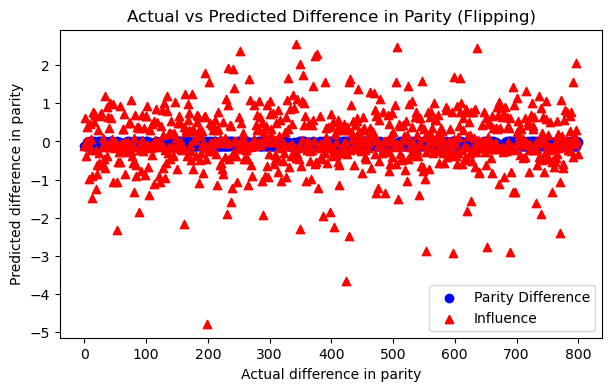

In [31]:
# Assuming the X-axis is some common range or specific values
x_values_list = range(len(flip_difference))  # X values for list data
x_values_array = range(len(inf))  # X values for ndarray data

# Create the plot
plt.figure(figsize=(7, 4))

# Plot list data with dots
plt.scatter(x_values_list, flip_difference, color='blue', label='Parity Difference', marker='o')

# Plot ndarray data with triangles
plt.scatter(x_values_array, decimal_array, color='red', label='Influence', marker='^')

# Adding labels
plt.xlabel('Actual difference in parity')
plt.ylabel('Predicted difference in parity')

# Adding title and legend
plt.title('Actual vs Predicted Difference in Parity (Flipping)')
plt.legend()

# Display the plot
plt.show()

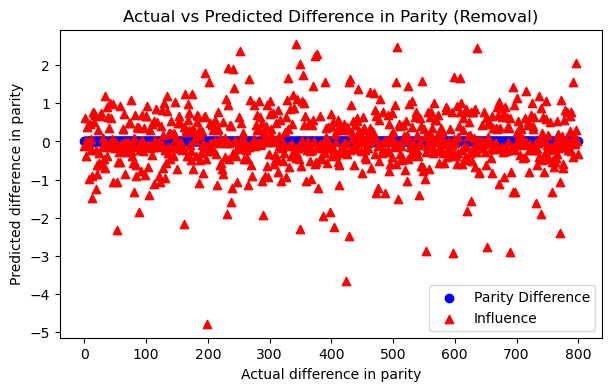

In [32]:
# Assuming the X-axis is some common range or specific values
x_values_list = range(len(remove_difference))  # X values for list data
x_values_array = range(len(inf))  # X values for ndarray data

# Create the plot
plt.figure(figsize=(7, 4))

# Plot list data with dots
plt.scatter(x_values_list, remove_difference, color='blue', label='Parity Difference', marker='o')

# Plot ndarray data with triangles
plt.scatter(x_values_array, decimal_array, color='red', label='Influence', marker='^')

# Adding labels
plt.xlabel('Actual difference in parity')
plt.ylabel('Predicted difference in parity')

# Adding title and legend
plt.title('Actual vs Predicted Difference in Parity (Removal)')
plt.legend()

# Display the plot
plt.show()

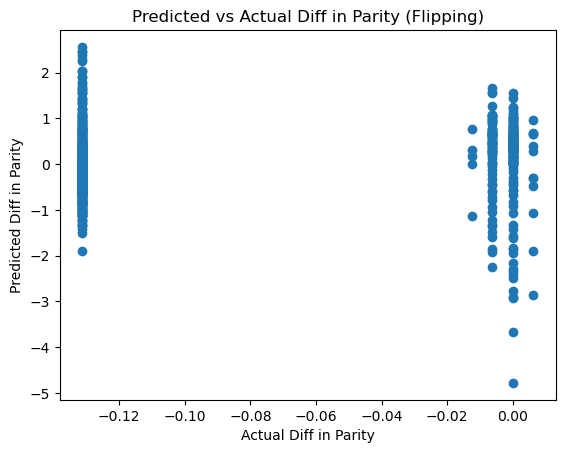

In [33]:
# Assuming your lists are named `predicted_diff` and `actual_diff`
predicted_diff = decimal_array
actual_diff = flip_difference

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff)

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (Flipping)')

# Show the plot
plt.show()

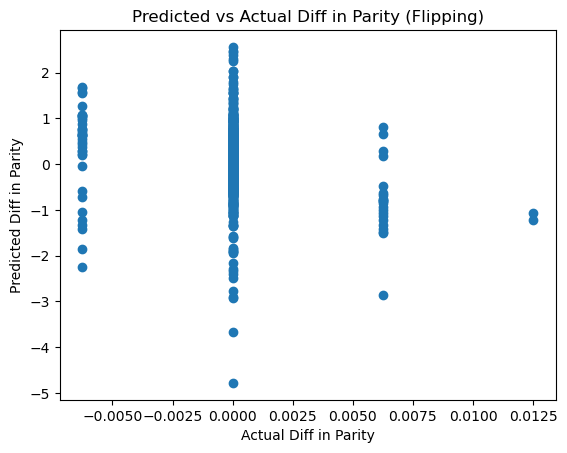

In [34]:
# Assuming your lists are named `predicted_diff` and `actual_diff`
predicted_diff = decimal_array
actual_diff = remove_difference

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff)

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (Flipping)')

# Show the plot
plt.show()

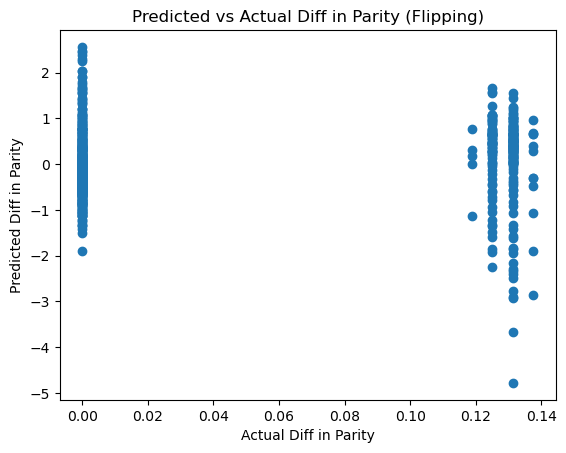

In [35]:
import matplotlib.pyplot as plt

# Assuming your lists are named `predicted_diff` and `actual_diff`
predicted_diff = decimal_array
actual_diff = flip_list

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff)

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (Flipping)')

# Show the plot
plt.show()

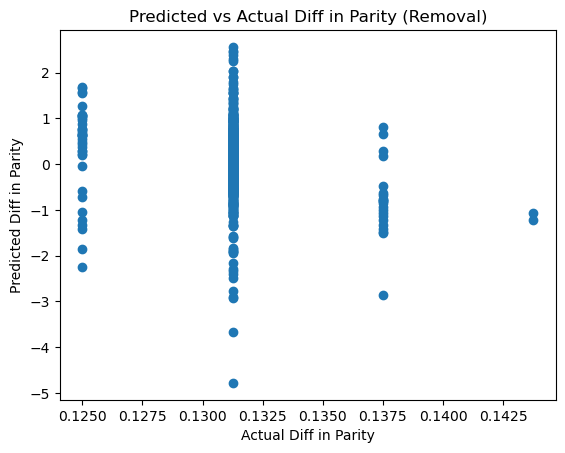

In [36]:
# Assuming your lists are named `predicted_diff` and `actual_diff`
predicted_diff = decimal_array
actual_diff = remove_list

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff)

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (Removal)')

# Show the plot
plt.show()

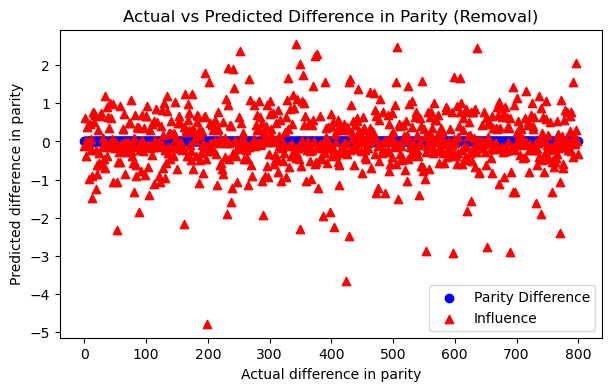

In [37]:
# Assuming the X-axis is some common range or specific values
x_values_list = range(len(remove_list))  # X values for list data
x_values_array = range(len(inf))  # X values for ndarray data

# Create the plot
plt.figure(figsize=(7, 4))

# Plot list data with dots
plt.scatter(x_values_list, remove_difference, color='blue', label='Parity Difference', marker='o')

# Plot ndarray data with triangles
plt.scatter(x_values_array, decimal_array, color='red', label='Influence', marker='^')

# Adding labels
plt.xlabel('Actual difference in parity')
plt.ylabel('Predicted difference in parity')

# Adding title and legend
plt.title('Actual vs Predicted Difference in Parity (Removal)')
plt.legend()

# Display the plot
plt.show()

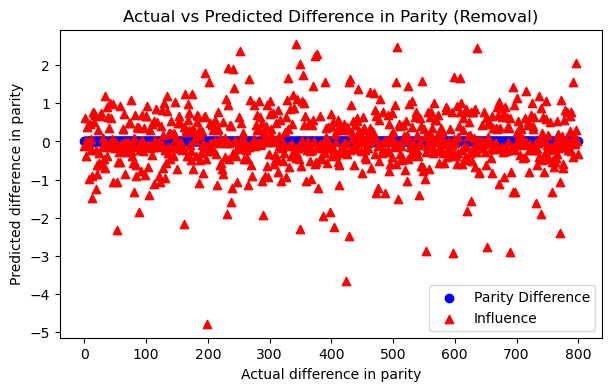

In [38]:
# Assuming the X-axis is some common range or specific values
x_values_list = range(len(flip_list))  # X values for list data
x_values_array = range(len(inf))  # X values for ndarray data

# Create the plot
plt.figure(figsize=(7, 4))

# Plot list data with dots
plt.scatter(x_values_list, remove_difference, color='blue', label='Parity Difference', marker='o')

# Plot ndarray data with triangles
plt.scatter(x_values_array, decimal_array, color='red', label='Influence', marker='^')

# Adding labels
plt.xlabel('Actual difference in parity')
plt.ylabel('Predicted difference in parity')

# Adding title and legend
plt.title('Actual vs Predicted Difference in Parity (Removal)')
plt.legend()

# Display the plot
plt.show()

In [39]:
print(decimal_array)
print(remove_list)

[-0.1080129016, 0.6151320721, 0.0011743644, -0.3681197939, 0.366397926, -0.0012043682, -0.0513559339, -0.1043851779, -0.9901991173, 0.4650802255, -0.2357594193, 0.0610738984, -0.9131498997, -1.4866311681, 0.7794422572, 0.7529111013, 0.4992993302, 0.6892438675, -1.2536715615, -0.2231775938, -0.8602337006, -0.6071625442, 0.291869902, -0.3071018561, -0.5547538576, 0.663063792, -0.6251613833, 0.7410572401, -0.6155677366, -0.1474075405, 0.0995056799, -0.4469856952, -0.111781323, 1.1817399139, -0.6829281422, -0.1110759459, -0.3856825562, 0.9099778509, 0.6435341974, -0.1441647316, 0.3476431174, -0.030003956, 1.010834238, 0.6169314922, 0.0553274881, -0.145271816, -1.0683244928, 0.9763397225, 0.0057808866, -0.053037834, -0.173788208, -0.0499409881, -2.3251593997, -1.0578587208, -0.5273060209, -0.1087311682, -0.2632133945, 0.9406994181, -0.5256479856, -0.1998892317, -0.0570667214, -0.0558984335, 0.3270354198, 0.3170827841, 0.7214422866, -0.0053790027, -0.8529723434, -0.2767111503, -0.033272705, 

<h5>Compare inf and list_difference and difference<h5>
<h5>Experiment 1: Datapoints that are close in value should be considered influential datapoints<h5>

In [40]:
#Compare the inf and list_difference values
#This is done to find the most influential datapoints across both the lists at the same time
#If the difference between the absolute value of the two lists is less than the original parity then those points are most influential
indices_in_range_flip = []

for i in range(len(inf)):
    diff = abs(inf[i]-flip_difference[i])

    if diff <= 0.13124999999999998:
        indices_in_range_flip.append(i)
print(indices_in_range_flip)


[0, 5, 6, 7, 10, 19, 29, 32, 35, 39, 41, 45, 49, 50, 51, 55, 59, 60, 61, 65, 68, 69, 70, 71, 73, 75, 78, 87, 90, 91, 95, 96, 101, 105, 107, 108, 111, 115, 117, 119, 121, 123, 125, 131, 135, 140, 147, 149, 151, 156, 157, 158, 159, 160, 171, 172, 190, 193, 199, 200, 201, 203, 205, 206, 209, 211, 218, 226, 229, 234, 248, 249, 250, 253, 260, 261, 262, 267, 269, 271, 273, 274, 276, 277, 283, 284, 286, 293, 297, 304, 310, 315, 316, 318, 320, 322, 323, 332, 334, 336, 341, 346, 347, 358, 360, 361, 363, 366, 368, 377, 379, 380, 382, 383, 387, 388, 391, 395, 396, 397, 403, 404, 408, 415, 416, 417, 421, 422, 424, 431, 438, 447, 448, 449, 455, 457, 458, 459, 460, 467, 474, 476, 480, 481, 483, 486, 490, 491, 497, 501, 502, 507, 509, 513, 527, 529, 532, 533, 536, 538, 541, 544, 555, 564, 570, 573, 576, 579, 584, 589, 591, 593, 596, 600, 611, 615, 619, 629, 634, 638, 641, 642, 646, 648, 655, 657, 658, 663, 664, 665, 666, 674, 677, 681, 683, 684, 687, 692, 693, 698, 699, 702, 709, 711, 715, 717, 721, 

In [41]:
print(inf[0])
print(flip_difference[0])


-0.10801290160632118
-0.13124999999999998


In [42]:
#Compare the inf and the difference values
indices_in_range_remove = []

for i in range(len(inf)):
    diff = abs(inf[i]-remove_difference[i])

    if diff <= 0.13124999999999998:
        indices_in_range_remove.append(i)
print(indices_in_range_remove)

[0, 2, 5, 6, 7, 11, 30, 32, 35, 41, 44, 48, 49, 51, 55, 60, 61, 65, 68, 69, 70, 71, 73, 78, 81, 93, 96, 101, 105, 108, 114, 115, 119, 121, 123, 125, 148, 151, 156, 171, 178, 179, 190, 193, 203, 205, 206, 211, 218, 219, 222, 226, 228, 229, 234, 243, 246, 250, 253, 255, 256, 258, 269, 271, 273, 274, 276, 277, 283, 284, 286, 290, 293, 297, 304, 305, 310, 315, 316, 322, 323, 332, 334, 336, 347, 352, 361, 362, 363, 372, 380, 382, 387, 388, 391, 395, 408, 421, 424, 433, 438, 443, 447, 449, 457, 458, 460, 461, 467, 474, 476, 480, 481, 485, 488, 497, 502, 507, 509, 513, 518, 519, 529, 532, 541, 544, 551, 555, 558, 566, 570, 577, 579, 582, 584, 590, 596, 599, 600, 605, 615, 631, 637, 638, 641, 642, 643, 645, 648, 653, 655, 657, 663, 665, 666, 687, 699, 702, 707, 709, 711, 712, 715, 717, 722, 731, 735, 738, 745, 750, 763, 769, 773, 774, 781, 784, 785, 790, 794, 795, 798]


In [43]:
#Removes datapoints based on the top points in the INF - remove_difference list
remove_parity = []
df_dropped= train_full_df.copy()
for i in range(len(indices_in_range_remove)):
    row_num = indices_in_range_remove[i]
    df_dropped = df_dropped.drop(row_num)
    accuracy, test_demo_df, predicted_df = logistic_regression_updated(df_dropped, X_test_orig,y_test, predictors,'credit_risk_12')
    parity = s_parity(test_demo_df, predictors, predicted_df, 'age', 1, 'credit_risk_12')
    remove_parity.append(parity-0.13124999999999998)

In [44]:
#With the indices figured out now I will go through the datasets and flip based on those indices
#copy_train_df = train_full_df.copy()
flip_parity = []
for i in range(len(indices_in_range_flip)):
    row_num = indices_in_range_flip[i]
    if train_full_df.at[row_num,'credit_risk'] == 1:
        train_full_df.at[row_num,'credit_risk'] = 2
        #copy_train_df = train_full_df.copy()
        accuracy, test_demo_df, predicted_df = logistic_regression_updated(train_full_df, X_test_orig, y_test, predictors,'credit_risk_12')
        parity = s_parity(X_test_orig, predictors, y_test, 'age', 1, 'credit_risk_12')
        flip_parity.append(parity)
    elif train_full_df.at[row_num,'credit_risk'] == 2:
        train_full_df.at[row_num,'credit_risk'] = 1
        #copy_train_df = train_full_df.copy()
        accuracy, test_demo_df, predicted_df = logistic_regression_updated(train_full_df, X_test_orig, y_test, predictors,'credit_risk_12')
        parity = s_parity(test_demo_df, predictors, predicted_df, 'age', 1, 'credit_risk_12')
        flip_parity.append(parity)
#flip_parity

        

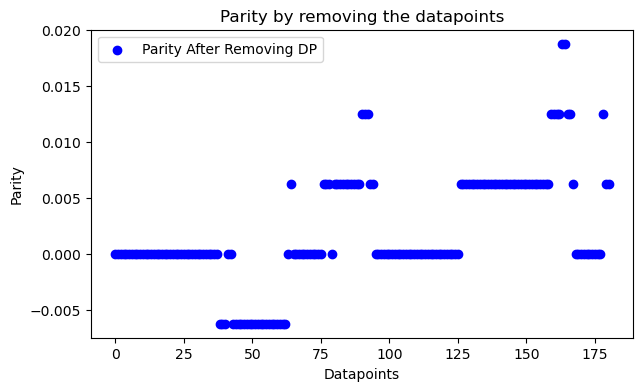

In [45]:
#Graph the points
# Assuming the X-axis is some common range or specific values
size = range(len(remove_parity))  # X values for list data


# Create the plot
plt.figure(figsize=(7, 4))

# Plot list data with dots
plt.scatter(size, remove_parity, color='blue', label='Parity After Removing DP', marker='o')

# Adding labels
plt.xlabel('Datapoints')
plt.ylabel('Parity')

# Adding title and legend
plt.title('Parity by removing the datapoints')
plt.legend()

# Display the plot
plt.show()

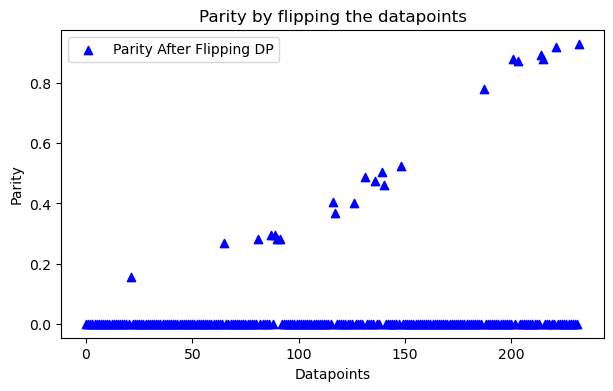

In [46]:
#Graph the points
# Assuming the X-axis is some common range or specific values
size = range(len(flip_parity))  # X values for list data


# Create the plot
plt.figure(figsize=(7, 4))

# Plot list data with dots
plt.scatter(size, flip_parity, color='blue', label='Parity After Flipping DP', marker='^')

# Adding labels
plt.xlabel('Datapoints')
plt.ylabel('Parity')

# Adding title and legend
plt.title('Parity by flipping the datapoints')
plt.legend()

# Display the plot
plt.show()

<h4>Flipping based on the INF list and determining whether positive or negative is good or bad<h4>

In [47]:
index_list = [i for i in range(len(train_full_df))]

In [48]:
#Get two lists
#Both of them are orderd
#One is ordered in abs value and the other is non-abs value
inf_sorted_list = index_list
abs_inf_sorted_list = index_list

In [49]:
# Step 1: Combine the lists into a list of tuples
#Sorted in ascending order
combined_list = list(zip(inf, inf_sorted_list))

# Step 2: Sort the combined list based on the float values
sorted_combined_list = sorted(combined_list, key=lambda x: x[0], reverse=True)

# Step 3: Unpack the sorted list of tuples back into two separate lists
sorted_float_list, sorted_index_list = zip(*sorted_combined_list)
list(sorted_float_list)
list(sorted_index_list)

[342,
 506,
 636,
 252,
 376,
 374,
 796,
 349,
 233,
 241,
 196,
 354,
 598,
 330,
 608,
 266,
 430,
 547,
 202,
 792,
 505,
 390,
 428,
 371,
 524,
 694,
 242,
 444,
 716,
 462,
 469,
 163,
 175,
 338,
 133,
 737,
 33,
 701,
 479,
 230,
 344,
 328,
 76,
 772,
 268,
 530,
 301,
 353,
 282,
 748,
 671,
 146,
 610,
 129,
 567,
 42,
 356,
 725,
 526,
 167,
 47,
 296,
 696,
 275,
 232,
 503,
 432,
 57,
 102,
 604,
 668,
 586,
 37,
 682,
 675,
 340,
 740,
 588,
 618,
 333,
 116,
 632,
 778,
 126,
 313,
 585,
 470,
 134,
 537,
 14,
 782,
 595,
 556,
 788,
 484,
 609,
 562,
 647,
 216,
 627,
 616,
 630,
 15,
 170,
 306,
 27,
 498,
 300,
 64,
 399,
 182,
 724,
 670,
 82,
 94,
 572,
 279,
 679,
 17,
 492,
 100,
 660,
 154,
 357,
 787,
 184,
 25,
 99,
 472,
 195,
 381,
 451,
 251,
 285,
 685,
 194,
 676,
 728,
 38,
 535,
 327,
 743,
 560,
 689,
 43,
 441,
 543,
 1,
 613,
 713,
 650,
 747,
 777,
 370,
 569,
 168,
 317,
 411,
 477,
 568,
 212,
 442,
 113,
 765,
 141,
 703,
 435,
 521,
 402,
 118,

In [50]:
print(sorted_float_list)

(2.56359037985851, 2.4842871495904553, 2.4470944324090844, 2.379782597392889, 2.29080805177224, 2.250936599972547, 2.0463014507826194, 2.035895309744262, 1.915838439926104, 1.9055296436638818, 1.8066443639100875, 1.744558139431832, 1.6853434473136577, 1.666169122214908, 1.6598451117075108, 1.6503572955305028, 1.6254724414589523, 1.5853764683196894, 1.5695292265833196, 1.5639625658670733, 1.5573999142683541, 1.553285570977313, 1.5465906579957853, 1.4580621235116273, 1.4544053330120033, 1.4332241561694483, 1.412722671354364, 1.3638450341326085, 1.3333829163946758, 1.3100177347008148, 1.2620792631734785, 1.2555257005933518, 1.2383533839052112, 1.2122945148068482, 1.200245431454225, 1.1975680723749553, 1.1817399139459097, 1.1511725016014835, 1.1173141878458173, 1.1036331060003783, 1.1009642633123822, 1.0849483806597213, 1.082551426023304, 1.076577449127019, 1.0757086259792468, 1.0709836314400474, 1.0698148168161126, 1.0616307711757813, 1.061346284576175, 1.0547499787291512, 1.0375861009375

In [51]:
combined_list = list(zip(inf, abs_inf_sorted_list))

# Step 2: Sort the combined list based on the float values
sorted_combined_list = sorted(combined_list, key=lambda x: abs(x[0]), reverse=True)

# Step 3: Unpack the sorted list of tuples back into two separate lists
abs_sorted_float_list, abs_sorted_index_list = zip(*sorted_combined_list)
list(abs_sorted_float_list)
list(abs_sorted_index_list)

[198,
 423,
 597,
 690,
 553,
 652,
 342,
 506,
 429,
 636,
 770,
 252,
 52,
 376,
 350,
 374,
 405,
 161,
 796,
 349,
 386,
 289,
 233,
 241,
 739,
 231,
 89,
 398,
 620,
 196,
 354,
 598,
 330,
 608,
 266,
 430,
 732,
 238,
 547,
 202,
 626,
 792,
 505,
 390,
 428,
 508,
 13,
 371,
 524,
 694,
 104,
 242,
 542,
 444,
 473,
 487,
 695,
 716,
 697,
 80,
 757,
 462,
 469,
 163,
 18,
 175,
 475,
 239,
 338,
 378,
 133,
 737,
 33,
 701,
 265,
 412,
 215,
 672,
 479,
 112,
 230,
 344,
 185,
 328,
 76,
 772,
 268,
 247,
 530,
 771,
 301,
 46,
 122,
 353,
 282,
 53,
 748,
 359,
 319,
 671,
 522,
 287,
 146,
 610,
 129,
 567,
 42,
 356,
 725,
 367,
 526,
 8,
 552,
 167,
 47,
 130,
 296,
 696,
 275,
 232,
 503,
 432,
 57,
 102,
 326,
 680,
 298,
 604,
 668,
 586,
 12,
 272,
 37,
 292,
 682,
 120,
 83,
 675,
 340,
 98,
 740,
 588,
 20,
 618,
 333,
 66,
 116,
 224,
 632,
 450,
 639,
 192,
 778,
 661,
 126,
 313,
 585,
 470,
 134,
 720,
 640,
 691,
 744,
 314,
 537,
 14,
 782,
 548,
 595,
 556,
 

In [52]:
print(abs_sorted_float_list)

(-4.780075336696747, -3.6666988602447836, -2.93163564248806, -2.8949399223744856, -2.868826032507486, -2.777568042405158, 2.56359037985851, 2.4842871495904553, -2.4785798509549224, 2.4470944324090844, -2.394090933575594, 2.379782597392889, -2.3251593997472124, 2.29080805177224, -2.287473063114118, 2.250936599972547, -2.2408033016706295, -2.1695987721275234, 2.0463014507826194, 2.035895309744262, -1.9441705746955877, -1.9295051227539612, 1.915838439926104, 1.9055296436638818, -1.894453389948651, -1.8900649757113932, -1.861302513985961, -1.8503625304066953, -1.8222977898846677, 1.8066443639100875, 1.744558139431832, 1.6853434473136577, 1.666169122214908, 1.6598451117075108, 1.6503572955305028, 1.6254724414589523, -1.6163167717209777, -1.5956296319217338, 1.5853764683196894, 1.5695292265833196, -1.5676568693196575, 1.5639625658670733, 1.5573999142683541, 1.553285570977313, 1.5465906579957853, -1.499135722423515, -1.4866311681091486, 1.4580621235116273, 1.4544053330120033, 1.43322415616944

In [53]:
#Flip the lists based on the ordered inf lists
#First do the absolute value list
flip_parity_abs = []
for i in range(len(abs_sorted_index_list)):
    row_num = abs_sorted_index_list[i]
    if train_full_df.at[row_num,'credit_risk'] == 1:
        train_full_df.at[row_num,'credit_risk'] = 2
        #copy_train_df = train_full_df.copy()
        accuracy, test_demo_df, predicted_df = logistic_regression_updated(train_full_df, X_test_orig, y_test, predictors,'credit_risk_12')
        parity = s_parity(X_test_orig , predictors, y_test, 'age', 1, 'credit_risk_12')
        flip_parity_abs.append(parity)
    elif train_full_df.at[row_num,'credit_risk'] == 2:
        train_full_df.at[row_num,'credit_risk'] = 1
        #copy_train_df = train_full_df.copy()
        accuracy, test_demo_df, predicted_df = logistic_regression_updated(train_full_df, X_test_orig, y_test, predictors,'credit_risk_12')
        parity = s_parity(test_demo_df, predictors, predicted_df, 'age', 1, 'credit_risk_12')
        flip_parity_abs.append(parity)
print(flip_parity_abs)

[0.9125, 0.91875, 0.9125, 0.91875, 0.91875, 0.9125, 0.0, 0.0, 0.9, 0.0, 0.88125, 0.0, 0.89375, 0.0, 0.9, 0.0, 0.9, 0.9, 0.0, 0.0, 0.89375, 0.90625, 0.0, 0.0, 0.89375, 0.0, 0.89375, 0.89375, 0.9, 0.0, 0.0, 0.0, 0.875, 0.0, 0.0, 0.0, 0.8624999999999999, 0.8374999999999999, 0.825, 0.0, 0.85, 0.79375, 0.0, 0.0, 0.7999999999999999, 0.0, 0.8374999999999999, 0.7999999999999999, 0.0, 0.0, 0.0, 0.0, 0.825, 0.0, 0.0, 0.83125, 0.8374999999999999, 0.0, 0.0, 0.83125, 0.0, 0.0, 0.8374999999999999, 0.83125, 0.0, 0.84375, 0.0, 0.0, 0.0, 0.85625, 0.0, 0.0, 0.84375, 0.0, 0.8374999999999999, 0.0, 0.0, 0.0, 0.85, 0.0, 0.83125, 0.0, 0.0, 0.8125, 0.0, 0.8062499999999999, 0.0, 0.8, 0.81875, 0.8125, 0.0, 0.0, 0.0, 0.8374999999999999, 0.8125, 0.0, 0.7937500000000001, 0.0, 0.84375, 0.0, 0.0, 0.0, 0.0, 0.81875, 0.81875, 0.0, 0.81875, 0.78125, 0.8062499999999999, 0.0, 0.0, 0.0, 0.0, 0.8062499999999999, 0.8125, 0.0, 0.7999999999999999, 0.8062499999999999, 0.0, 0.71875, 0.0, 0.69375, 0.725, 0.71875, 0.70625, 0.0, 0

In [54]:
#Flip the lists based on the ordered inf lists
#Normal sorted list
flip_parity_sorted = []
for i in range(len(sorted_index_list)):
    row_num = sorted_index_list[i]
    if train_full_df.at[row_num,'credit_risk'] == 1:
        train_full_df.at[row_num,'credit_risk'] = 2
        #copy_train_df = train_full_df.copy()
        accuracy, test_demo_df, predicted_df = logistic_regression_updated(train_full_df, X_test_orig, y_test, predictors,'credit_risk_12')
        parity = s_parity(X_test_orig , predictors, y_test, 'age', 1, 'credit_risk_12')
        flip_parity_sorted.append(parity)
    elif train_full_df.at[row_num,'credit_risk'] == 2:
        train_full_df.at[row_num,'credit_risk'] = 1
        #copy_train_df = train_full_df.copy()
        accuracy, test_demo_df, predicted_df = logistic_regression_updated(train_full_df, X_test_orig, y_test, predictors,'credit_risk_12')
        parity = s_parity(test_demo_df, predictors, predicted_df, 'age', 1, 'credit_risk_12')
        flip_parity_sorted.append(parity)
print(flip_parity_sorted)

[-0.925, -0.91875, -0.91875, -0.91875, -0.9125, -0.90625, -0.90625, -0.85625, -0.8624999999999999, -0.8624999999999999, -0.8125, -0.8187500000000001, -0.7875, 0.0, -0.76875, -0.7625, -0.76875, 0.0, -0.75625, 0.0, -0.75, -0.6875, 0.0, 0.0, -0.7, -0.6499999999999999, -0.61875, -0.5875, -0.53125, -0.575, 0.0, 0.0, 0.0, -0.5125, -0.49999999999999994, -0.49374999999999997, 0.0, -0.42499999999999993, 0.0, 0.0, -0.38749999999999996, 0.0, -0.36874999999999997, 0.0, -0.325, 0.0, -0.325, 0.0, 0.0, 0.0, -0.25, -0.19999999999999996, 0.0, 0.0, -0.15000000000000002, 0.0, 0.0, 0.0, -0.125, 0.0, 0.0, 0.0, 0.0, -0.018749999999999933, 0.0, -0.006249999999999978, 0.0, 0.0, 0.0, -0.006249999999999978, 0.0, 0.0, 0.06874999999999998, 0.0, 0.07499999999999996, 0.0, 0.0, 0.11250000000000004, 0.11250000000000004, 0.11250000000000004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15000000000000002, 0.0, 0.15625, 0.15000000000000002, 0.16875000000000007, 0.20625000000000004, 0.0, 0.20625000000000004, 0.0, 0.20625000000000004, 0.22

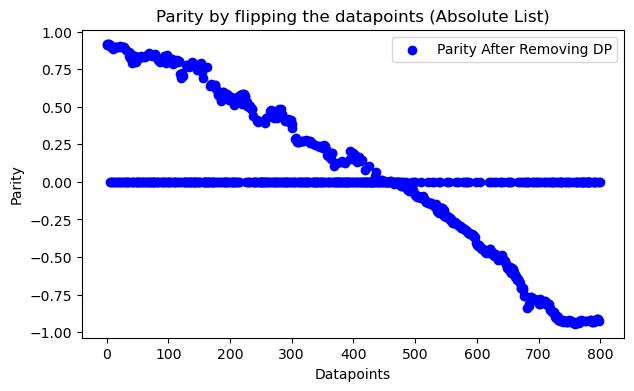

In [55]:
#Graph the points
# Assuming the X-axis is some common range or specific values
size = range(len(flip_parity_abs))  # X values for list data


# Create the plot
plt.figure(figsize=(7, 4))

# Plot list data with dots
plt.scatter(size, flip_parity_abs, color='blue', label='Parity After Removing DP', marker='o')

# Adding labels
plt.xlabel('Datapoints')
plt.ylabel('Parity')

# Adding title and legend
plt.title('Parity by flipping the datapoints (Absolute List)')
plt.legend()

# Display the plot
plt.show()

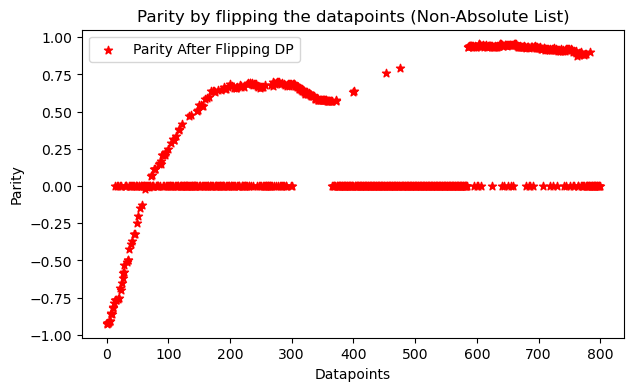

In [56]:
#Graph the points
# Assuming the X-axis is some common range or specific values
size = range(len(flip_parity_sorted))  # X values for list data


# Create the plot
plt.figure(figsize=(7, 4))

# Plot list data with dots
plt.scatter(size, flip_parity_sorted, color='red', label='Parity After Flipping DP', marker='*')

# Adding labels
plt.xlabel('Datapoints')
plt.ylabel('Parity')

# Adding title and legend
plt.title('Parity by flipping the datapoints (Non-Absolute List)')
plt.legend()

# Display the plot
plt.show()

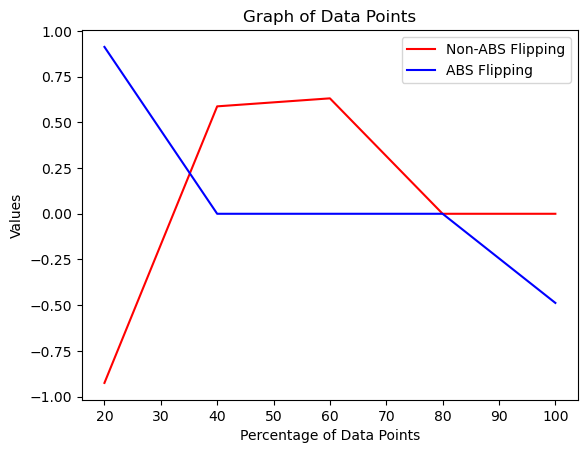

In [57]:
#total num of data points
non_abs_sorted = len(flip_parity_sorted)
abs_sorted = len(flip_parity_abs)

#Calculate the indices for the 5 points
indices_non_abs = [int(i * non_abs_sorted / 5) for i in range(0, 5)]
indices_abs = [int(i * abs_sorted / 5) for i in range(0, 5)]

# Extract the values at these indices
values_non_abs = [flip_parity_sorted[index] for index in indices_non_abs]
values_abs = [flip_parity_abs[index] for index in indices_abs]

#Plot the Values
plt.plot([20, 40, 60, 80, 100], values_non_abs, label='Non-ABS Flipping', color='Red')
plt.plot([20, 40, 60, 80, 100], values_abs, label='ABS Flipping', color='Blue')

# Add labels and legend
plt.xlabel('Percentage of Data Points')
plt.ylabel('Values')
plt.title('Graph of Data Points')
plt.legend()

# Show the plot
plt.show()


